<a href="https://colab.research.google.com/github/rdsmaia/dim0494/blob/main/mnist_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [179]:
# bibliotecas
import torch
import torchvision
import random
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader
from torch import optim
from tqdm import tqdm
from sklearn.metrics import confusion_matrix

In [146]:
# GPU ou não
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device = {device}\n')
print(f'Properties: {torch.cuda.get_device_properties(device=device)}\n')

Device = cuda

Properties: _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40)



In [152]:
# define transformada das imagens, incluindo normalização
transform = torchvision.transforms.Compose([
    # transforma imagens em tensores
    torchvision.transforms.ToTensor(),
])

In [153]:
# carrega base de dados
# treino
train_data = torchvision.datasets.MNIST(
    root = 'data',
    train = True,
    download = True,
    transform = transform
)
# teste
test_data = torchvision.datasets.MNIST(
    root = 'data',
    train = False,
    download = True,
    transform = transform
)

In [154]:
# imprime dados
print(f'Training dataset: \n{train_data}\n')
print(f'Test dataset: \n{test_data}\n')

Training dataset: 
Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
           )

Test dataset: 
Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
           )



In [155]:
# ver o formato dos dados
print(f'Training data format: {train_data.data.shape}\n')
print(f'Test data format: {test_data.data.shape}\n')

Training data format: torch.Size([60000, 28, 28])

Test data format: torch.Size([10000, 28, 28])



In [158]:
# verifica os valores
print(f'Min-max da base de treino: {train_data.data.min().item(), train_data.data.max().item()}\n')
print(f'Min-max da base de teste: {test_data.data.min().item(), test_data.data.max().item()}\n')
print(f'Min-max targets de treino: {train_data.targets.min().item(), train_data.targets.max().item()}\n')
print(f'Min-max targets de teste: {test_data.targets.min().item(), test_data.targets.max().item()}\n')

Min-max da base de treino: (0, 255)

Min-max da base de teste: (0, 255)

Min-max targets de treino: (0, 9)

Min-max targets de teste: (0, 9)



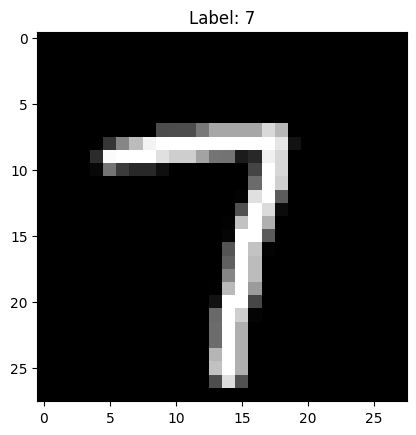

In [159]:
# vamos olhar uma imagem aleatória da base de treino
ind = random.randint(0,len(train_data))
plt.imshow(train_data.data[ind], cmap='gray')
plt.title(f'Label: {train_data.targets[ind]}')
plt.show()

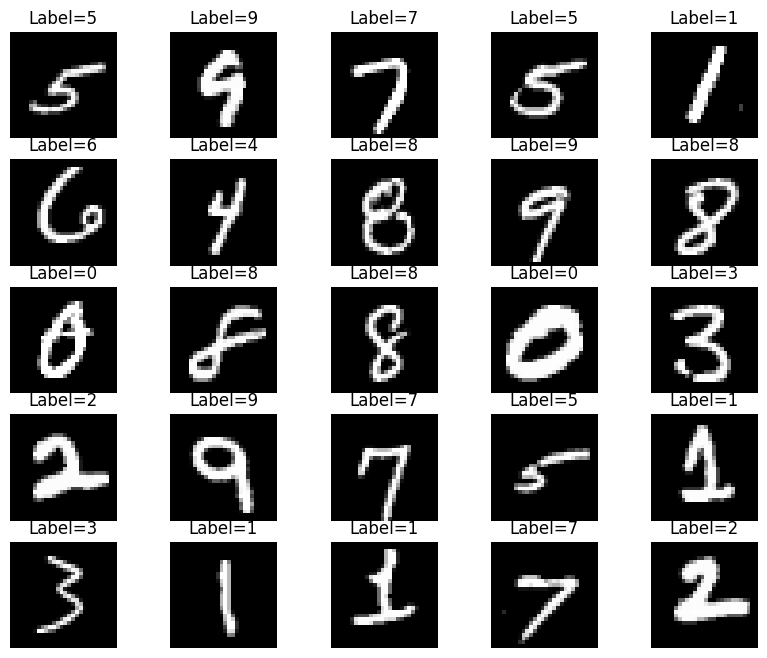

In [160]:
# agora vamos olhar várias imagens
figure = plt.figure(figsize=(10, 8))
cols, rows = 5, 5
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_data), size=(1,)).item()
    img, label = train_data.data[sample_idx], train_data.targets[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(f'Label={label.item()}')
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [161]:
# hiperparâmetros
num_epochs = 10
learning_rate = 0.01
batch_size = 120
log_steps = 100
test_batch_size = len(test_data) // (len(train_data) // batch_size)
print(f'Batch size for the test data {test_batch_size}\n')

Batch size for the test data 20



In [162]:
# criação do gerador de dados
loaders = {
    'train' : DataLoader(train_data,
                         batch_size=batch_size,
                         shuffle=True),

    'test'  : DataLoader(test_data,
                         batch_size=test_batch_size,
                         shuffle=True),
}

In [167]:
# imprime dois lotes
for i, batch in enumerate(loaders['train']):
  # imprime formato, máximos e mínimos de X
  print(f'batch {i}, X shape: {batch[0].shape}, min: {batch[0].min().item()}, max: {batch[0].max().item()}')
  #imprime formato, máximos e mínimos de y
  print(f'batch {i}, y shape: {batch[1].shape}, min: {batch[1].min().item()}, max: {batch[1].max().item()}')
  if i == 3:
    break

batch 0, X shape: torch.Size([120, 1, 28, 28]), min: 0.0, max: 1.0
batch 0, y shape: torch.Size([120]), min: 0, max: 9
batch 1, X shape: torch.Size([120, 1, 28, 28]), min: 0.0, max: 1.0
batch 1, y shape: torch.Size([120]), min: 0, max: 9
batch 2, X shape: torch.Size([120, 1, 28, 28]), min: 0.0, max: 1.0
batch 2, y shape: torch.Size([120]), min: 0, max: 9
batch 3, X shape: torch.Size([120, 1, 28, 28]), min: 0.0, max: 1.0
batch 3, y shape: torch.Size([120]), min: 0, max: 9


In [168]:
# modelo
class CNN(nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    # primeira camada convolucional
    self.conv1 = nn.Sequential(
          nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=5,
                stride=1,
                padding=2
          ),
          nn.ReLU(),
          nn.MaxPool2d(kernel_size=2),
        )
    # segunda camada convolucional
    self.conv2 = nn.Sequential(
          nn.Conv2d(in_channels=16,
                    out_channels=32,
                    kernel_size=5,
                    stride=1,
                    padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
        )
    # transforma mapa de atributes 2d em um vetor 1d
    self.flatten = nn.Flatten()

    # camada ff final com 10 saídas
    self.out = nn.Linear(in_features=32 * 7 * 7,
                         out_features=10)

  def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.flatten(x)
        output = self.out(x)
        return output

In [169]:
# imprime modelo
cnn = CNN()
print(cnn)

CNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (out): Linear(in_features=1568, out_features=10, bias=True)
)


In [170]:
# definição da função custo
loss_func = nn.CrossEntropyLoss()

In [171]:
# define o otimizador
optimizer = optim.Adam(
    cnn.parameters(),
    lr = learning_rate # taxa de aprendizado
    )
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [172]:
# Verifica se o modelo funciona para base de dados
for i, batch in enumerate(loaders['train']):
  # imagem
  X = batch[0]
  # etiqueta
  y = batch[1]
  # etiqueta predita
  y_hat = cnn(X)
  # error (custo)
  loss = loss_func(y_hat, y)
  print(f'For batch {i}, loss = {loss}')
  if i == 2:
    break

For batch 0, loss = 2.3079795837402344
For batch 1, loss = 2.3065383434295654
For batch 2, loss = 2.3114407062530518


In [174]:
# definição da função de treino
def train(num_epochs, cnn, loaders):

  # determina o modo treino
  cnn.train()

  # número de batches na based de treino
  total_step = len(loaders['train'])

  accum_loss = []
  accum_loss_val = []

  # faça para cada época
  for epoch in range(num_epochs):

    # faça para cada batch
    for i, ((X, y), (X_val, y_val)) in enumerate(zip(loaders['train'], loaders['test'])):

      # saída da rede
      y_hat = cnn(X)

      # erro da saída da rede
      loss = loss_func(y_hat, y)

      # passa dados de validação pelo modelo
      y_val_hat = cnn(X_val)

      # calcula erro na base de validação
      loss_val = loss_func(y_val_hat, y_val)

      # clear gradients for this training step
      optimizer.zero_grad()

      # backpropagation, compute gradients
      loss.backward()

      # apply gradients
      optimizer.step()

      if (i+1) % log_steps == 0:
        print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Val Loss: {:.4f}'
                       .format(epoch + 1, num_epochs, i + 1, total_step, loss.item(), loss_val.item()))
      accum_loss.append(loss.item())
      accum_loss_val.append(loss_val.item())

  return accum_loss, accum_loss_val

In [175]:
# treinamento da rede
accum_loss, accum_loss_val = train(num_epochs, cnn, loaders)

Epoch [1/10], Step [100/500], Loss: 0.1592, Val Loss: 0.0689
Epoch [1/10], Step [200/500], Loss: 0.0378, Val Loss: 0.0311
Epoch [1/10], Step [300/500], Loss: 0.0646, Val Loss: 0.0455
Epoch [1/10], Step [400/500], Loss: 0.1573, Val Loss: 0.0118
Epoch [1/10], Step [500/500], Loss: 0.2219, Val Loss: 0.0073
Epoch [2/10], Step [100/500], Loss: 0.0994, Val Loss: 0.0093
Epoch [2/10], Step [200/500], Loss: 0.0588, Val Loss: 0.2807
Epoch [2/10], Step [300/500], Loss: 0.0507, Val Loss: 0.1215
Epoch [2/10], Step [400/500], Loss: 0.1019, Val Loss: 0.0269
Epoch [2/10], Step [500/500], Loss: 0.0552, Val Loss: 0.0068
Epoch [3/10], Step [100/500], Loss: 0.0671, Val Loss: 0.0041
Epoch [3/10], Step [200/500], Loss: 0.0537, Val Loss: 0.0239
Epoch [3/10], Step [300/500], Loss: 0.0483, Val Loss: 0.0023
Epoch [3/10], Step [400/500], Loss: 0.0983, Val Loss: 0.0003
Epoch [3/10], Step [500/500], Loss: 0.0362, Val Loss: 0.0093
Epoch [4/10], Step [100/500], Loss: 0.0083, Val Loss: 0.0032
Epoch [4/10], Step [200/

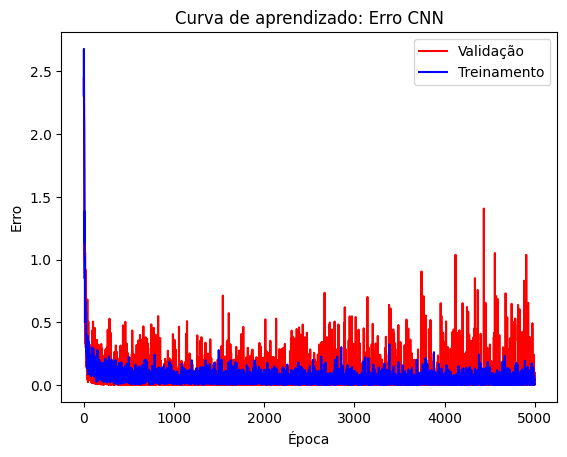

In [176]:
# produz as curvas de aprendizado
plt.figure()
plt.plot(accum_loss_val, 'r', label="Validação")
plt.plot(accum_loss, 'b', label="Treinamento")
plt.title("Curva de aprendizado: Erro CNN")
plt.xlabel("Época")
plt.ylabel("Erro")
plt.legend()

In [181]:
# definição de uma função para teste
def test(loaders):

    pred_labels = []
    true_labels = []
    ncorrect = 0.0

    # ajusta o modelo para modo teste
    cnn.eval()

    # determina que não é préciso calcular gradientes
    with torch.no_grad():

        # para cada batch de teste
        for X_test, y_test in tqdm(loaders['test'], total=len(loaders['test'])):

            # passa o lote pelo modelo
            y_test_hat = cnn(X_test)

            # determina o índice máximo
            pred_y_test = torch.argmax(y_test_hat, dim=-1)

            # número de corretos
            ncorrect += (pred_y_test == y_test).sum().item()

            # acumula valores preditos
            pred_labels.extend(pred_y_test)
            true_labels.extend(y_test)
        # acurácia média
        acc = ncorrect / len(test_data)
        print(f'Mean accuracy: {acc}')

    # matrix de confusão
    cm = confusion_matrix(true_labels, pred_labels)
    sns.heatmap(cm, annot=True, fmt='.0f', cmap='Blues')

100%|██████████| 500/500 [00:03<00:00, 125.37it/s]


Mean accuracy: 0.9853


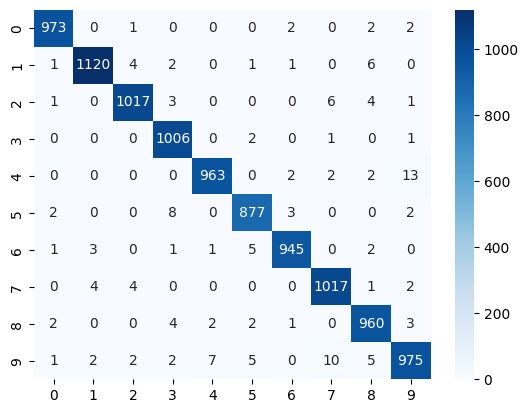

In [182]:
# testar o modelo
test(loaders)